### bureau와 bureau_bal 데이터 세트 기반의 EDA와 Feature Engineering 수행 후 학습 모델 생성/평가

#### 라이브러리 및 데이터 세트 로딩.

In [3]:
import numpy as np
import pandas as pd
import gc  # garbage collection
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)

##### 코랩 버전은 Google Drive에서 데이터 세트를 로딩

In [4]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import os, sys
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
default_dir = "/content/gdrive/My Drive"

def get_dataset():
  """
  1.apps - 현 대출정보 데이터셋
  2.prev - 이전 기관에서 대출정보 데이터셋
  3. bureau - 타 금융기관 대출
  4. bureau_bal - 타기관금융 대출금액 잔액정보
  """
  app_train = pd.read_csv(os.path.join(default_dir, 'application_train.csv'))
  app_test  = pd.read_csv(os.path.join(default_dir, 'application_test.csv'))
  apps = pd.concat([app_train, app_test])

  prev = pd.read_csv(os.path.join(default_dir, 'previous_application.csv'))
  bureau = pd.read_csv(os.path.join(default_dir, 'bureau.csv'))
  bureau_bal = pd.read_csv(os.path.join(default_dir, 'bureau_balance.csv'))
  return apps, prev, bureau, bureau_bal

apps, prev, bureau, bureau_bal = get_dataset()

### bureau와 bureau_balance 컬럼 설명

|Table|컬럼명|컬럼 대분류|컬럼 중분류|컬럼 설명|
|------|--------|----|--------|-----------------|
|bureau.csv|SK_ID_CURR|대출|고유ID|현재 대출 고유 ID|
|bureau.csv|SK_BUREAU_ID|대출|고유ID|타 기관 대출 고유 ID|
|bureau.csv|CREDIT_ACTIVE|대출|대출 상태|대출 상태(Active: 대출 상환중, Closed: 상환 완료)|
|bureau.csv|CREDIT_CURRENCY|대출|대출 금액|대출 금액 화폐유형|
|bureau.csv|DAYS_CREDIT|대출|행동|현재 대출 신청 일 기준 과거 대출 신청 지난 기간|
|bureau.csv|CREDIT_DAY_OVERDUE|대출|행동|대출 신청 시 CB 크레딧 연체 일수|
|bureau.csv|DAYS_CREDIT_ENDDATE|대출|상태|CB 크레딧 채무 완료까지 남아있는 일수(신청일 기준)|
|bureau.csv|DAYS_ENDDATE_FACT|대출|상태|CB 크레딧 채무 완료까지 걸린 실제 일수(신청일 기준, 상태가 Close일때만)|
|bureau.csv|AMT_CREDIT_MAX_OVERDUE|대출|상태|최대 연체금액|
|bureau.csv|CNT_CREDIT_PROLONG|대출|상태|신용 연장 횟수|
|bureau.csv|AMT_CREDIT_SUM|대출|대출 금액|현재 크레딧 금액 총액|
|bureau.csv|AMT_CREDIT_SUM_DEBT|대출|대출 금액|현재 채무 금액 총액|
|bureau.csv|AMT_CREDIT_SUM_LIMIT|대출|대출 금액|신용 카드 현재 신용한도|
|bureau.csv|AMT_CREDIT_SUM_OVERDUE|대출|상태|현재 연체 금액|
|bureau.csv|CREDIT_TYPE|대출|대출 유형|크레딧 유형|
|bureau.csv|DAYS_CREDIT_UPDATE|대출|대출 행동|대출 신청전 마지막 정보 받은 기간|
|bureau.csv|AMT_ANNUITY|대출|대출 금액|월 대출 지급액|
|bureau_balance.csv|SK_BUREAU_ID|대출|고유ID|타 기관 대출 고유 ID|
|bureau_balance.csv|MONTHS_BALANCE|대출|상태|신청일 기준 잔액 월 |
|bureau_balance.csv|STATUS|대출|상태|월별 대출 상태(Active: 대출 상환중, Closed: 상환 완료, DPD0-30: 30일 이전 연체 상태등|


In [9]:
bureau.head(20)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.00,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.80,42103.80,0.00,0.0,Consumer credit,-22,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.00,0.00,0.0,Consumer credit,-1710,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,103007.70,0.00,0.00,0.0,Consumer credit,-840,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,4500.00,0.00,0.00,0.0,Credit card,-690,NaN


##### bureau, bureau_bal 컬럼 및 Null 조사 

In [10]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [11]:
# DAYS_ENDDATE_FACT, AMT_CREDIT_MAX_OVERDUE, AMT_CREDIT_SUM_LIMT, AMT_ANNUITY 등이 Null 컬럼이 많음. 
# 널값 찾기
bureau.isnull().sum()

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

In [12]:
bureau_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [14]:
bureau_bal.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [15]:
# C : Closed(상환완료), X:Unknown, 0 - 연체 초기(일수의 범위를 의미)
bureau_bal.head(10)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


In [ ]:
bureau[bureau['SK_ID_BUREAU'] == 5715448].head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
768,380361,5715448,Active,currency 1,-820,0,31069.0,NaN,NaN,0,67500.0,0.0,67500.0,0.0,Credit card,-183,0.0


#### 숫자형 피처들의 Histogram을 TARGET 유형에 따라 비교

In [17]:
# TARGET 값을 가져오기 위해 bureau를 apps와 조인
bureau_app = bureau.merge(apps[['SK_ID_CURR', 'TARGET']], on ='SK_ID_CURR', how = 'left')

In [22]:
# 숫자형 피처만 뽑기
num_columns = bureau_app.dtypes[bureau_app.dtypes != 'object'].index.to_list()

# 숫자형 컬럼은 SK_ID_CURR와 TARGET은 제외
num_columns = [column for column in num_columns if column not in ['SK_ID_CURR', 'TARGET', 'SK_ID_BUREAU']]
display(num_columns)

['DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'AMT_ANNUITY']

In [24]:
bureau_app[num_columns].head(10)

,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,-497,0,-153.0,-153.0,NaN,0,91323.00,0.00,NaN,0.0,-131,NaN
1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.00,NaN,0.0,-20,NaN
2,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,-16,NaN
3,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,-16,NaN
4,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,-21,NaN
5,-273,0,27460.0,NaN,0.0,0,180000.00,71017.38,108982.62,0.0,-31,NaN
6,-43,0,79.0,NaN,0.0,0,42103.80,42103.80,0.00,0.0,-22,NaN
7,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.00,0.00,0.0,-1710,NaN
8,-1146,0,-811.0,-840.0,0.0,0,103007.70,0.00,0.00,0.0,-840,NaN
9,-1146,0,-484.0,NaN,0.0,0,4500.00,0.00,0.00,0.0,-690,NaN


In [25]:
# 유한한 값만 가져오기 
np.isfinite(bureau_app[num_columns])

,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,True,True,True,True,False,True,True,True,False,True,True,False
1,True,True,True,False,False,True,True,True,False,True,True,False
2,True,True,True,False,False,True,True,False,False,True,True,False
3,True,True,False,False,False,True,True,False,False,True,True,False
4,True,True,True,False,True,True,True,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,True,True,True,False,True,True,True,True,True,True,True,False
1716424,True,True,True,True,True,True,True,True,True,True,True,False
1716425,True,True,True,True,False,True,True,False,False,True,True,False
1716426,True,True,True,True,False,True,True,True,True,True,True,False


column: DAYS_CREDIT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column: CREDIT_DAY_OVERDUE


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column: DAYS_CREDIT_ENDDATE


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column: DAYS_ENDDATE_FACT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column: AMT_CREDIT_MAX_OVERDUE


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column: CNT_CREDIT_PROLONG


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column: AMT_CREDIT_SUM


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column: AMT_CREDIT_SUM_DEBT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column: AMT_CREDIT_SUM_LIMIT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column: AMT_CREDIT_SUM_OVERDUE


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column: DAYS_CREDIT_UPDATE


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column: AMT_ANNUITY


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


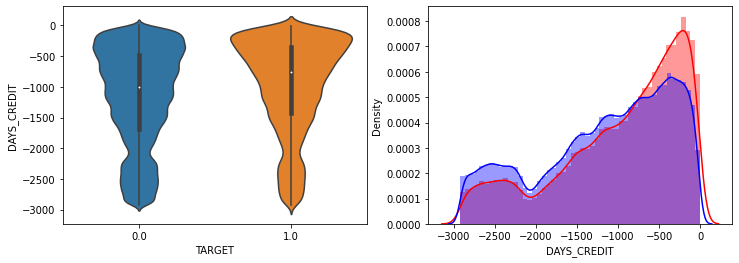

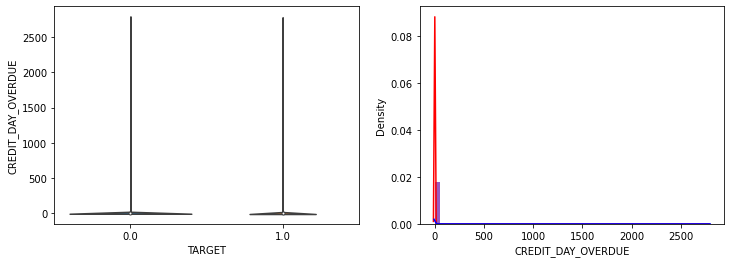

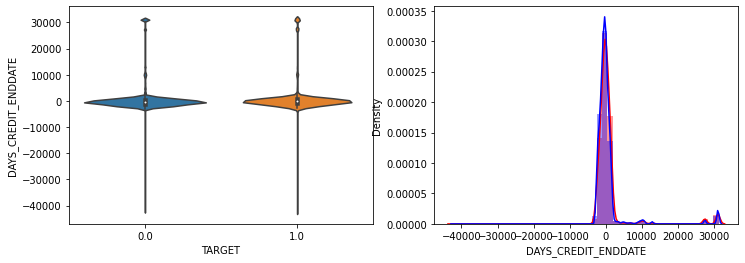

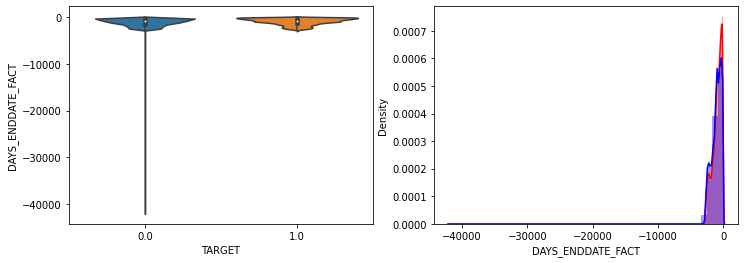

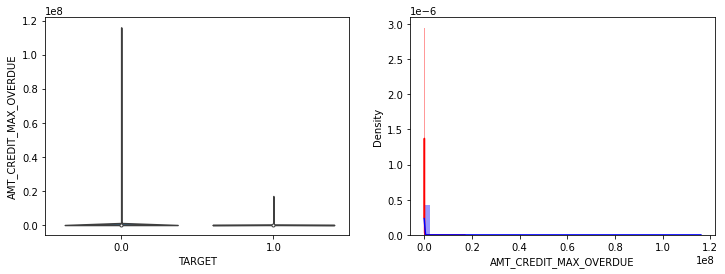

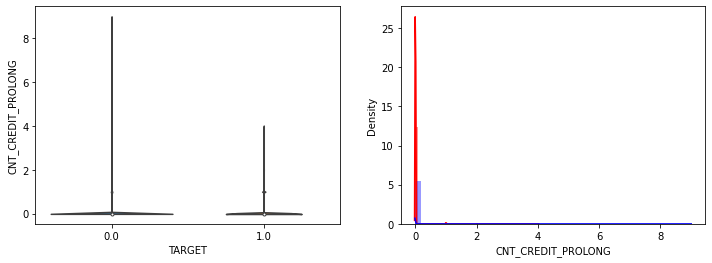

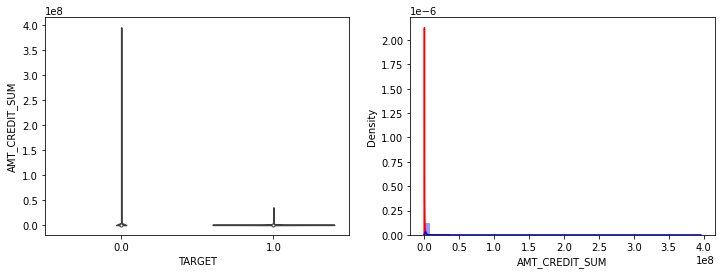

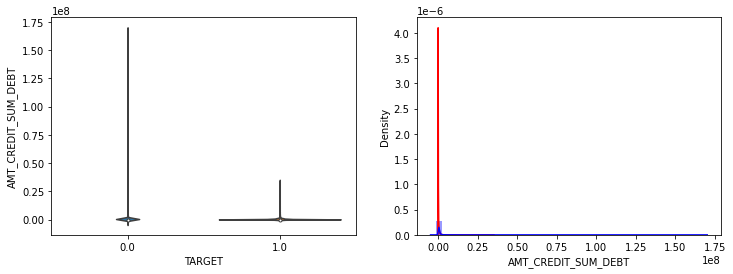

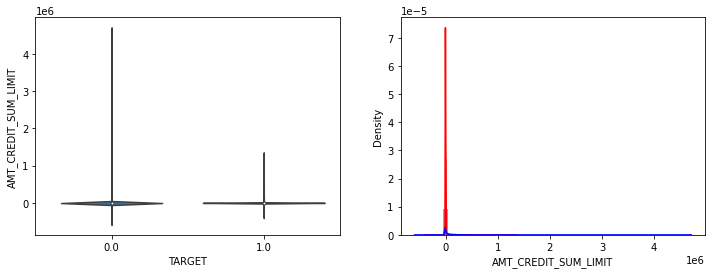

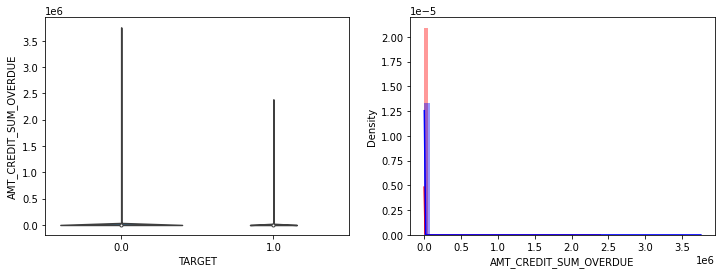

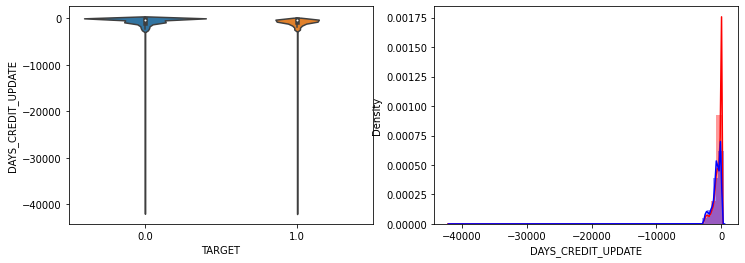

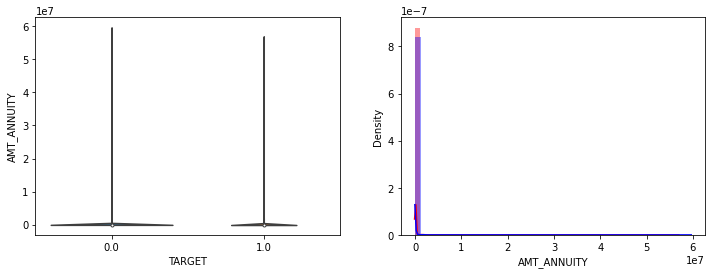

In [31]:
def show_history_by_target(df, columns):
  """
  타겟값과 기타 숫자형 피처들간의 관계 보기 
  """
  cond_1 = (df['TARGET']== 1)
  cond_0 = (df['TARGET']== 0)


  for column in columns:
    print('column:', column)

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 4), squeeze=False)

    #bureau는 특정컬럼값이 infinite로 들어가있는 경우가 있음.
    #infinite일 경우 KDE histogram 시각화시 문제 발생하여 이를 제거함.(이상치 제거 )
    sns.violinplot(x = 'TARGET', y = column, data = df[np.isfinite(df[column])], ax = axs[0][0])
    sns.distplot(df[cond_1 &  np.isfinite(df[column])][column], label = '1', color='red', ax = axs[0][1])
    sns.distplot(df[cond_0 &  np.isfinite(df[column])][column], label = '0', color='blue', ax = axs[0][1])

show_history_by_target(bureau_app, num_columns)

In [32]:
np.isfinite(bureau_app['AMT_CREDIT_SUM_LIMIT']).sum() # 무한하지 않은값(유한값)

1124648

* DAYS_CREDIT는 TARGET=1 일때 상대적으로 최근에 더 빈번하게 대출.
* 나머지 컬럼들은 의미있는 차이를 찾기 어려움

#### Category 피처들의 Histogram을 TARGET 유형에 따라 비교

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

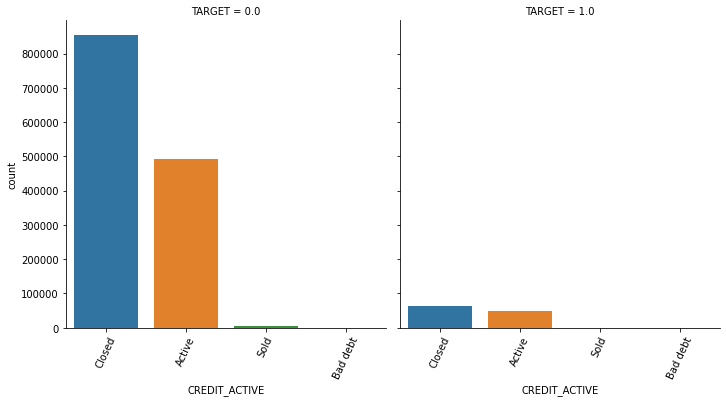

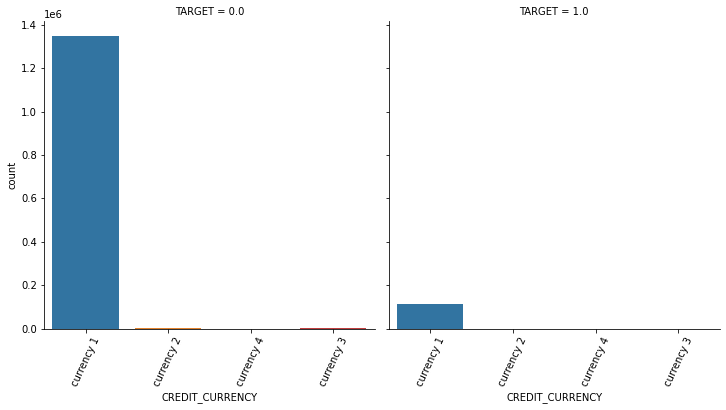

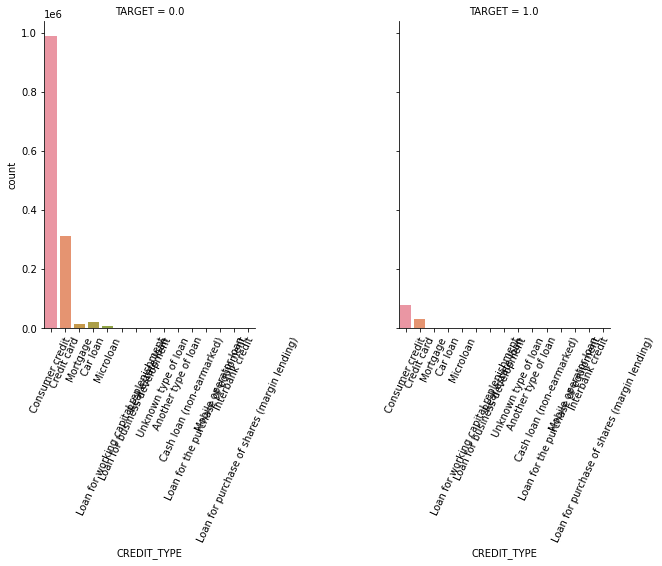

In [34]:
object_columns = bureau_app.dtypes[bureau_app.dtypes == 'object'].index.to_list()
display(object_columns)

def show_category(df, columns):
  """
  타겟별 범주형 피처의 분포 시각화
  """
  for column in columns:
    chart = sns.catplot(x = column, col = 'TARGET', data = df, kind = 'count')
    chart.set_xticklabels(rotation = 65)

show_category(bureau_app, object_columns)

* 현재 상태가 Active인 건이 TARGET이 1일때 비율이 높아짐. 

##### bureau 채무 완료 날짜 및 대출 금액 대비 채무 금액 관련 컬럼 가공. 

In [36]:
def get_bureau_processed(bureau):
  """
  bureau 채무 완료 날짜 및 대출 금액 대비 채무 금액 관련 컬럼 가공.
  """
  # 예정 채무 시작(DAYS_CREDIT_ENDDATE) 및 완료일과 실제 채무 완료일(DAYS_ENDDATE_FACT)간의 차이 및 날짜 비율 가공. 
  # 1. 채무완료일(DAYS_CREDIT_ENDDATE)과 실제 채무완료일(DAYS_ENDDATE_FACT)의 차이
  # 2. 현재 대출 신청 일 기준 과거 대출 신청 지난 기간(DAYS_CREDIT)
  # 3. CB 크레딧 채무 완료까지 걸린 실제 일수(신청일 기준, 상태가 Close일때만) - DAYS_ENDDATE_FACT


  # BUREAU_CREDIT_FACT_DIFF : 채무변제 완료까기 걸린 날짜
  # BUREAU_ENDDATE_FACT_DIFF : 채무변제예상일수와 실채무변제완료일과의 차이 .
  # BUREAU_CREDIT_ENDDATE_DIFF : 예상채무변재일까지 남은 일수.
  bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
  bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
  bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']

  # 채무 금액 대비/대출 금액 비율 및 차이 가공
  # BUREAU_CREDIT_DEBT_RATIO : 현재 CREDIT총 대출금액/ 현재 CREIDT총액 금액
  # BUREAU_CREDIT_DEBT_DIFF : 현재 CREDIT총 대출금액 - 현재 CREIDT총액 금액
  bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
  bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']

  # 연체 및 연체 120일 
  bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if  x > 0 else 0)
  bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if  x > 120 else 0)

  return bureau

In [35]:
# 예정 채무 시작(DAYS_CREDIT_ENDDATE) 및 완료일과 실제 채무 완료일(DAYS_ENDDATE_FACT)간의 차이 및 날짜 비율 가공. 
# 1. 채무완료일(DAYS_CREDIT_ENDDATE)과 실제 채무완료일(DAYS_ENDDATE_FACT)의 차이
# 2. 현재 대출 신청 일 기준 과거 대출 신청 지난 기간(DAYS_CREDIT)
# 3. CB 크레딧 채무 완료까지 걸린 실제 일수(신청일 기준, 상태가 Close일때만) - DAYS_ENDDATE_FACT


# BUREAU_CREDIT_FACT_DIFF : 채무변제 완료까기 걸린 날짜
# BUREAU_ENDDATE_FACT_DIFF : 채무변제예상일수와 실채무변제완료일과의 차이 .
# BUREAU_CREDIT_ENDDATE_DIFF : 예상채무변재일까지 남은 일수.
bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']

# 채무 금액 대비/대출 금액 비율 및 차이 가공
# BUREAU_CREDIT_DEBT_RATIO : 현재 CREDIT총 대출금액/ 현재 CREIDT총액 금액
# BUREAU_CREDIT_DEBT_DIFF : 현재 CREDIT총 대출금액 - 현재 CREIDT총액 금액
bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']

In [37]:
bureau['AMT_CREDIT_SUM_DEBT'].value_counts().head(30)  # 채무금액의 빈도

 0.0          1016434
 4.5              653
-450.0            543
 135000.0         344
 90000.0          320
 45000.0          316
 22500.0          307
 67500.0          238
 225000.0         237
 13500.0          205
 450000.0         177
 112500.0         156
 18000.0          143
 157500.0         139
 27000.0          132
 54000.0          125
 9000.0           121
 270000.0         107
 22950.0          101
 900000.0          98
 675000.0          97
 180000.0          97
 9.0               94
 225.0             88
-45.0              84
 31500.0           84
 36000.0           81
 450.0             81
 1350000.0         81
 49500.0           81
Name: AMT_CREDIT_SUM_DEBT, dtype: int64

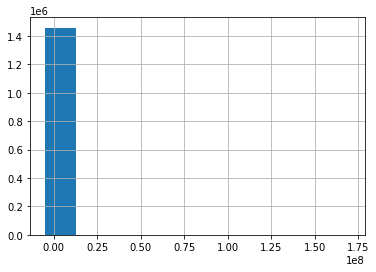

In [38]:
bureau['AMT_CREDIT_SUM_DEBT'].hist()

##### 연체 일수 CREDIT_DAY_OVERDUE로 연체 관련 FE 수행. 

In [39]:
# 연체 건수가 많지 않음. 
bureau['CREDIT_DAY_OVERDUE'].value_counts()

0       1712211
30          311
60          126
13          103
8           103
         ...   
1548          1
1546          1
519           1
2565          1
372           1
Name: CREDIT_DAY_OVERDUE, Length: 942, dtype: int64

##### 연체일수가 0보다 큰건, 120보다 큰건 조사

In [40]:
bureau[bureau['CREDIT_DAY_OVERDUE'] > 0].shape

(4217, 22)

In [41]:
bureau[bureau['CREDIT_DAY_OVERDUE'] > 120].shape

(1143, 22)

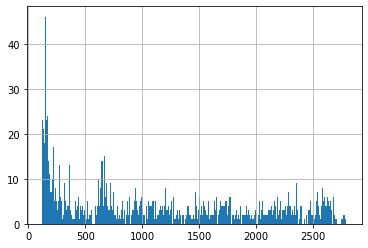

In [42]:
bureau[bureau['CREDIT_DAY_OVERDUE'] > 120]['CREDIT_DAY_OVERDUE'].hist(bins = 300)

##### 연체일수에 따라 연체인지, 연체가 120일이상인지 컬럼 가공

In [43]:
bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >0 else 0)
bureau['BUREAU_IS_DPD'].value_counts()

0    1712211
1       4217
Name: BUREAU_IS_DPD, dtype: int64

In [44]:
# 4개월
bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if  x > 120 else 0)
bureau['BUREAU_IS_DPD_OVER120'].value_counts()

0    1715285
1       1143
Name: BUREAU_IS_DPD_OVER120, dtype: int64

##### 기존 주요 bureau 컬럼 및 앞에서 가공한 컬럼으로 주요 aggregation 컬럼 생성. 

In [49]:
def get_bureau_day_amt_agg(df):
  """
  타 금융기관의 대출 피처에 대한 파생컬럼추가 
  """
  bureau_agg_dict = {
    # 기존 컬럼
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],
    # 추가 가공 컬럼
    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
  }
  bureau_grp = df.groupby('SK_ID_CURR')
  bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)

  # BUREAU_ 접두어로 하는 새로운 컬럼명 할당.
  bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
  
  # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
  bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
  print(bureau_day_amt_agg.shape)
  
  return bureau_day_amt_agg

bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)

(305811, 47)


In [50]:
bureau_day_amt_agg.head(5)

,SK_ID_CURR,BUREAU_SK_ID_BUREAU_COUNT,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_ENDDATE_FACT_MIN,BUREAU_DAYS_ENDDATE_FACT_MAX,BUREAU_DAYS_ENDDATE_FACT_MEAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_SUM,BUREAU_BUREAU_ENDDATE_FACT_DIFF_MIN,BUREAU_BUREAU_ENDDATE_FACT_DIFF_MAX,BUREAU_BUREAU_ENDDATE_FACT_DIFF_MEAN,BUREAU_BUREAU_CREDIT_FACT_DIFF_MIN,BUREAU_BUREAU_CREDIT_FACT_DIFF_MAX,BUREAU_BUREAU_CREDIT_FACT_DIFF_MEAN,BUREAU_BUREAU_CREDIT_ENDDATE_DIFF_MIN,BUREAU_BUREAU_CREDIT_ENDDATE_DIFF_MAX,BUREAU_BUREAU_CREDIT_ENDDATE_DIFF_MEAN,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MIN,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MAX,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,BUREAU_BUREAU_CREDIT_DEBT_DIFF_MIN,BUREAU_BUREAU_CREDIT_DEBT_DIFF_MAX,BUREAU_BUREAU_CREDIT_DEBT_DIFF_MEAN,BUREAU_BUREAU_IS_DPD_MEAN,BUREAU_BUREAU_IS_DPD_SUM,BUREAU_BUREAU_IS_DPD_OVER120_MEAN,BUREAU_BUREAU_IS_DPD_OVER120_SUM
0,100001,7,-1572,-49,-735.000000,0,0,0.0,-1329.0,1778.0,82.428571,-1328.0,-544.0,-825.500000,NaN,NaN,378000.0,207623.571429,1453365.000,373239.0,85240.928571,596686.5,0.0,0.0,0.0,10822.5,3545.357143,24817.5,-1.0,698.0,197.0,-335.0,-32.0,-228.750000,-1827.0,-243.0,-817.428571,0.0,0.987405,0.282518,-279720.0,-4761.0,-122382.642857,0.0,0,0.0,0
1,100002,8,-1437,-103,-874.000000,0,0,0.0,-1072.0,780.0,-349.000000,-1185.0,-36.0,-697.500000,5043.645,1681.029,450000.0,108131.945625,865055.565,245781.0,49156.200000,245781.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1029.0,252.6,-609.0,-76.0,-277.000000,-1822.0,-87.0,-719.833333,0.0,0.546180,0.136545,-204219.0,0.0,-98388.513000,0.0,0,0.0,0
2,100003,4,-2586,-606,-1400.750000,0,0,0.0,-2434.0,1216.0,-544.500000,-2131.0,-540.0,-1097.333333,0.000,0.000,810000.0,254350.125000,1017400.500,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,0.0,-303.0,201.0,-34.0,-1096.0,-154.0,-568.333333,-1822.0,-152.0,-856.250000,0.0,0.000000,0.000000,-810000.0,-22248.0,-254350.125000,0.0,0,0.0,0
3,100004,2,-1326,-408,-867.000000,0,0,0.0,-595.0,-382.0,-488.500000,-683.0,-382.0,-532.500000,0.000,0.000,94537.8,94518.900000,189037.800,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,88.0,44.0,-643.0,-26.0,-334.500000,-731.0,-26.0,-378.500000,0.0,0.000000,0.000000,-94537.8,-94500.0,-94518.900000,0.0,0,0.0,0
4,100005,3,-373,-62,-190.666667,0,0,0.0,-128.0,1324.0,439.333333,-123.0,-123.0,-123.000000,0.000,0.000,568800.0,219042.000000,657126.000,543087.0,189469.500000,568408.5,0.0,0.0,0.0,4261.5,1420.500000,4261.5,-5.0,-5.0,-5.0,-250.0,-250.0,-250.000000,-1461.0,-184.0,-630.000000,0.0,0.954794,0.601256,-58500.0,-4504.5,-29572.500000,0.0,0,0.0,0


#### 현재 대출 중 Active인 건만 별도로 Group by 수행(CREDIT_ACTIVE='Active')

In [51]:
def get_bureau_active_agg(df):
  """
  현재 대출중 상환중인 대출건만 별도로 GROUPBY
  """
  cond_active = df['CREDIT_ACTIVE'] == 'Active'
  bureau_ative_grp = df[cond_active].groupby('SK_ID_CURR')
  bureau_agg_dit = {
    # 기존 컬럼
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],
    # 추가 가공 컬럼
    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
  }
  bureau_active_agg = bureau_ative_grp.agg(bureau_agg_dit)
  bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
  bureau_active_agg = bureau_active_agg.reset_index()
  
  return bureau_active_agg

In [52]:
bureau_active_agg = get_bureau_active_agg(bureau)
print(bureau_active_agg.shape)

(251815, 47)


In [53]:
bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on = 'SK_ID_CURR', how = 'left')
bureau_agg.head(5)

,SK_ID_CURR,BUREAU_SK_ID_BUREAU_COUNT,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_ENDDATE_FACT_MIN,BUREAU_DAYS_ENDDATE_FACT_MAX,BUREAU_DAYS_ENDDATE_FACT_MEAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_SUM,BUREAU_BUREAU_ENDDATE_FACT_DIFF_MIN,BUREAU_BUREAU_ENDDATE_FACT_DIFF_MAX,BUREAU_BUREAU_ENDDATE_FACT_DIFF_MEAN,BUREAU_BUREAU_CREDIT_FACT_DIFF_MIN,BUREAU_BUREAU_CREDIT_FACT_DIFF_MAX,BUREAU_BUREAU_CREDIT_FACT_DIFF_MEAN,BUREAU_BUREAU_CREDIT_ENDDATE_DIFF_MIN,BUREAU_BUREAU_CREDIT_ENDDATE_DIFF_MAX,BUREAU_BUREAU_CREDIT_ENDDATE_DIFF_MEAN,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MIN,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MAX,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,BUREAU_BUREAU_CREDIT_DEBT_DIFF_MIN,BUREAU_BUREAU_CREDIT_DEBT_DIFF_MAX,BUREAU_BUREAU_CREDIT_DEBT_DIFF_MEAN,BUREAU_BUREAU_IS_DPD_MEAN,BUREAU_BUREAU_IS_DPD_SUM,BUREAU_BUREAU_IS_DPD_OVER120_MEAN,BUREAU_BUREAU_IS_DPD_OVER120_SUM,BUREAU_ACT_SK_ID_BUREAU_COUNT,BUREAU_ACT_DAYS_CREDIT_MIN,BUREAU_ACT_DAYS_CREDIT_MAX,BUREAU_ACT_DAYS_CREDIT_MEAN,BUREAU_ACT_CREDIT_DAY_OVERDUE_MIN,BUREAU_ACT_CREDIT_DAY_OVERDUE_MAX,BUREAU_ACT_CREDIT_DAY_OVERDUE_MEAN,BUREAU_ACT_DAYS_CREDIT_ENDDATE_MIN,BUREAU_ACT_DAYS_CREDIT_ENDDATE_MAX,BUREAU_ACT_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_ACT_DAYS_ENDDATE_FACT_MIN,BUREAU_ACT_DAYS_ENDDATE_FACT_MAX,BUREAU_ACT_DAYS_ENDDATE_FACT_MEAN,BUREAU_ACT_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_ACT_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_ACT_AMT_CREDIT_SUM_MAX,BUREAU_ACT_AMT_CREDIT_SUM_MEAN,BUREAU_ACT_AMT_CREDIT_SUM_SUM,BUREAU_ACT_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_ACT_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_ACT_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_ACT_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_ACT_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_ACT_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_ACT_AMT_ANNUITY_MAX,BUREAU_ACT_AMT_ANNUITY_MEAN,BUREAU_ACT_AMT_ANNUITY_SUM,BUREAU_ACT_BUREAU_ENDDATE_FACT_DIFF_MIN,BUREAU_ACT_BUREAU_ENDDATE_FACT_DIFF_MAX,BUREAU_ACT_BUREAU_ENDDATE_FACT_DIFF_MEAN,BUREAU_ACT_BUREAU_CREDIT_FACT_DIFF_MIN,BUREAU_ACT_BUREAU_CREDIT_FACT_DIFF_MAX,BUREAU_ACT_BUREAU_CREDIT_FACT_DIFF_MEAN,BUREAU_ACT_BUREAU_CREDIT_ENDDATE_DIFF_MIN,BUREAU_ACT_BUREAU_CREDIT_ENDDATE_DIFF_MAX,BUREAU_ACT_BUREAU_CREDIT_ENDDATE_DIFF_MEAN,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MIN,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MEAN,BUREAU_ACT_BUREAU_CREDIT_DEBT_DIFF_MIN,BUREAU_ACT_BUREAU_CREDIT_DEBT_DIFF_MAX,BUREAU_ACT_BUREAU_CREDIT_DEBT_DIFF_MEAN,BUREAU_ACT_BUREAU_IS_DPD_MEAN,BUREAU_ACT_BUREAU_IS_DPD_SUM,BUREAU_ACT_BUREAU_IS_DPD_OVER120_MEAN,BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM
0,100001,7,-1572,-49,-735.000000,0,0,0.0,-1329.0,1778.0,82.428571,-1328.0,-544.0,-825.500000,NaN,NaN,378000.0,207623.571429,1453365.000,373239.0,85240.928571,596686.5,0.0,0.0,0.0,10822.5,3545.357143,24817.5,-1.0,698.0,197.0,-335.0,-32.0,-228.750000,-1827.0,-243.0,-817.428571,0.0,0.987405,0.282518,-279720.0,-4761.0,-122382.642857,0.0,0,0.0,0,3.0,-559.0,-49.0,-309.333333,0.0,0.0,0.0,411.0,1778.0,1030.333333,NaN,NaN,NaN,NaN,NaN,378000.0,294675.0000,884025.000,373239.0,198895.50,596686.5,0.0,0.0,0.0,10822.5,8272.50,24817.5,NaN,NaN,NaN,NaN,NaN,NaN,-1827.0,-731.0,-1339.666667,0.335128,0.987405,0.659208,-224514.0,-4761.000,-95779.5000,0.0,0.0,0.0,0.0
1,100002,8,-1437,-103,-874.000000,0,0,0.0,-1072.0,780.0,-349.000000,-1185.0,-36.0,-697.500000,5043.645,1681.029,450000.0,108131.945625,865055.565,245781.0,49156.200000,245781.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1029.0,252.6,-609.0,-76.0,-277.000000,-1822.0,-8

In [54]:
bureau_agg.shape

(305811, 93)

##### SK_ID_CURR레벨로 건수 대비 연체 OVER 0, OVER 120 건수 비율 계산

In [55]:
select_columns = ['SK_ID_CURR', 'BUREAU_SK_ID_BUREAU_COUNT', 'BUREAU_BUREAU_IS_DPD_SUM', 'BUREAU_BUREAU_IS_DPD_OVER120_SUM','BUREAU_ACT_BUREAU_IS_DPD_SUM', 'BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']
bureau_agg[select_columns].head(20) 

,SK_ID_CURR,BUREAU_SK_ID_BUREAU_COUNT,BUREAU_BUREAU_IS_DPD_SUM,BUREAU_BUREAU_IS_DPD_OVER120_SUM,BUREAU_ACT_BUREAU_IS_DPD_SUM,BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM
0,100001,7,0,0,0.0,0.0
1,100002,8,0,0,0.0,0.0
2,100003,4,0,0,0.0,0.0
3,100004,2,0,0,NaN,NaN
4,100005,3,0,0,0.0,0.0
5,100007,1,0,0,NaN,NaN
6,100008,3,0,0,0.0,0.0
7,100009,18,0,0,0.0,0.0
8,100010,2,0,0,0.0,0.0
9,100011,4,0,0,NaN,NaN


In [56]:
bureau_agg['BUREAU_BUREAU_IS_DPD_SUM'].value_counts()

0    301947
1      3615
2       186
3        39
4        13
5         6
6         4
7         1
Name: BUREAU_BUREAU_IS_DPD_SUM, dtype: int64

In [57]:
# SK_ID_CURR 레벨로 DPD 비율, DPD > 120 비율 확률, Active 상태에서 DPD 비율, DPD > 120 비율 확률
bureau_agg['BUREAU_IS_DPD_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
bureau_agg['BUREAU_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
bureau_agg['BUREAU_ACT_IS_DPD_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
bureau_agg['BUREAU_ACT_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']

In [58]:
bureau_agg.head(10)

,SK_ID_CURR,BUREAU_SK_ID_BUREAU_COUNT,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_ENDDATE_FACT_MIN,BUREAU_DAYS_ENDDATE_FACT_MAX,BUREAU_DAYS_ENDDATE_FACT_MEAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_SUM,BUREAU_BUREAU_ENDDATE_FACT_DIFF_MIN,BUREAU_BUREAU_ENDDATE_FACT_DIFF_MAX,BUREAU_BUREAU_ENDDATE_FACT_DIFF_MEAN,BUREAU_BUREAU_CREDIT_FACT_DIFF_MIN,BUREAU_BUREAU_CREDIT_FACT_DIFF_MAX,BUREAU_BUREAU_CREDIT_FACT_DIFF_MEAN,BUREAU_BUREAU_CREDIT_ENDDATE_DIFF_MIN,BUREAU_BUREAU_CREDIT_ENDDATE_DIFF_MAX,BUREAU_BUREAU_CREDIT_ENDDATE_DIFF_MEAN,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MIN,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MAX,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,BUREAU_BUREAU_CREDIT_DEBT_DIFF_MIN,BUREAU_BUREAU_CREDIT_DEBT_DIFF_MAX,BUREAU_BUREAU_CREDIT_DEBT_DIFF_MEAN,BUREAU_BUREAU_IS_DPD_MEAN,BUREAU_BUREAU_IS_DPD_SUM,BUREAU_BUREAU_IS_DPD_OVER120_MEAN,BUREAU_BUREAU_IS_DPD_OVER120_SUM,BUREAU_ACT_SK_ID_BUREAU_COUNT,BUREAU_ACT_DAYS_CREDIT_MIN,BUREAU_ACT_DAYS_CREDIT_MAX,BUREAU_ACT_DAYS_CREDIT_MEAN,BUREAU_ACT_CREDIT_DAY_OVERDUE_MIN,BUREAU_ACT_CREDIT_DAY_OVERDUE_MAX,BUREAU_ACT_CREDIT_DAY_OVERDUE_MEAN,BUREAU_ACT_DAYS_CREDIT_ENDDATE_MIN,BUREAU_ACT_DAYS_CREDIT_ENDDATE_MAX,BUREAU_ACT_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_ACT_DAYS_ENDDATE_FACT_MIN,BUREAU_ACT_DAYS_ENDDATE_FACT_MAX,BUREAU_ACT_DAYS_ENDDATE_FACT_MEAN,BUREAU_ACT_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_ACT_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_ACT_AMT_CREDIT_SUM_MAX,BUREAU_ACT_AMT_CREDIT_SUM_MEAN,BUREAU_ACT_AMT_CREDIT_SUM_SUM,BUREAU_ACT_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_ACT_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_ACT_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_ACT_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_ACT_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_ACT_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_ACT_AMT_ANNUITY_MAX,BUREAU_ACT_AMT_ANNUITY_MEAN,BUREAU_ACT_AMT_ANNUITY_SUM,BUREAU_ACT_BUREAU_ENDDATE_FACT_DIFF_MIN,BUREAU_ACT_BUREAU_ENDDATE_FACT_DIFF_MAX,BUREAU_ACT_BUREAU_ENDDATE_FACT_DIFF_MEAN,BUREAU_ACT_BUREAU_CREDIT_FACT_DIFF_MIN,BUREAU_ACT_BUREAU_CREDIT_FACT_DIFF_MAX,BUREAU_ACT_BUREAU_CREDIT_FACT_DIFF_MEAN,BUREAU_ACT_BUREAU_CREDIT_ENDDATE_DIFF_MIN,BUREAU_ACT_BUREAU_CREDIT_ENDDATE_DIFF_MAX,BUREAU_ACT_BUREAU_CREDIT_ENDDATE_DIFF_MEAN,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MIN,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MEAN,BUREAU_ACT_BUREAU_CREDIT_DEBT_DIFF_MIN,BUREAU_ACT_BUREAU_CREDIT_DEBT_DIFF_MAX,BUREAU_ACT_BUREAU_CREDIT_DEBT_DIFF_MEAN,BUREAU_ACT_BUREAU_IS_DPD_MEAN,BUREAU_ACT_BUREAU_IS_DPD_SUM,BUREAU_ACT_BUREAU_IS_DPD_OVER120_MEAN,BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM,BUREAU_IS_DPD_RATIO,BUREAU_IS_DPD_OVER120_RATIO,BUREAU_ACT_IS_DPD_RATIO,BUREAU_ACT_IS_DPD_OVER120_RATIO
0,100001,7,-1572,-49,-735.000000,0,0,0.0,-1329.0,1778.0,82.428571,-1328.0,-544.0,-825.500000,NaN,NaN,378000.0,207623.571429,1453365.000,373239.0,85240.928571,596686.5,0.0,0.0,0.0,10822.5,3545.357143,24817.5,-1.0,698.0,197.000000,-335.0,-32.0,-228.750000,-1827.0,-243.0,-817.428571,0.0,0.987405,0.282518,-279720.0,-4761.0,-122382.642857,0.0,0,0.0,0,3.0,-559.0,-49.0,-309.333333,0.0,0.0,0.0,411.0,1778.0,1030.333333,NaN,NaN,NaN,NaN,NaN,378000.0,294675.0000,884025.000,373239.0,198895.500,596686.5,0.0,0.0,0.0,10822.5,8272.50,24817.5,NaN,NaN,NaN,NaN,NaN,NaN,-1827.0,-731.0,-1339.666667,0.335128,0.987405,0.659208,-224514.0,-4761.000,-95779.5000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,8,-1437,-103,-874.000000,0,0,0.0,-1072.0,780.0,-349.000000,-1185.0,-36.0,-697.500000,5043.645,1681.029,450000.0,108131.9456

##### bureau_bal의 주요 컬럼으로 aggregation 컬럼 생성. 

##### bureau_bal을 SK_ID_CURR 별로 groupby 하기 위해 SK_ID_CURR을 가지고 있는 bureau와 조인 

In [7]:
# 데이터 세트 재로딩. 
apps, prev, bureau, bureau_bal = get_dataset()

In [60]:
print(bureau_bal.shape, bureau.shape)

# bureau_bal과 bureau join
# bureau_bal이 다 나와야 하는 left 조인
bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')  # 
bureau_bal.shape

(27299925, 3) (1716428, 17)


(27299925, 4)

##### bureau_bal의 주요 컬럼으로 SK_ID_CURR레벨의 aggregation 컬럼 생성. 

In [61]:
bureau_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,SK_ID_CURR
0,5715448,0,C,380361.0
1,5715448,-1,C,380361.0
2,5715448,-2,C,380361.0
3,5715448,-3,C,380361.0
4,5715448,-4,C,380361.0


##### STATUS 컬럼에 따른 연체 OVER 0 , OVER 120 값 가공. 
* 0 - 계속 갚아가고 연체가 아님.
* 1 - 30일 연체
* 2 - 60일 연체

In [62]:
bureau_bal['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [63]:
bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x : 1 if x in ['1', '2', '3', '4', '5'] else 0)
bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x : 1 if x =='5' else 0)

In [60]:
bureau_bal['BUREAU_BAL_IS_DPD'].value_counts()

0    26956982
1      342943
Name: BUREAU_BAL_IS_DPD, dtype: int64

In [78]:
bureau_bal.head()  # 월별 연체라고 할 수 있음

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [68]:
def get_bureau_bal_agg(df):
  """
  SK_ID_CURR 레벨로 건수와 MONTHS_BALANCE의 aggregation 가공
  """
  bureau_bal_grp = df.groupby('SK_ID_CURR')
  bureau_bal_agg_dit = {
    'SK_ID_CURR':['count'],
    'MONTHS_BALANCE':['min', 'max', 'mean'],
    'BUREAU_BAL_IS_DPD':['mean', 'sum'],
    'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']
  }
  bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dit)
  bureau_bal_agg.columns = ['BUREAU_BAL_'+ ('_').join(column).upper() for column in bureau_bal_agg.columns.ravel()]

  # SK_ID_CURR 레벨로 DPD 비율, DPD > 120 비율 가공 
  bureau_bal_agg['BUREAU_BAL_IS_DPD_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']
  bureau_bal_agg['BUREAU_BAL_IS_DPD_OVER120_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']

  # 조인을 위해 SK_ID_CURR를 reset_index()로 컬럼화
  bureau_bal_agg = bureau_bal_agg.reset_index()
  return bureau_bal_agg

In [69]:
bureau_bal_agg = get_bureau_bal_agg(bureau_bal)
display(bureau_bal_agg.shape, bureau_bal_agg.head(10)) 

(134542, 11)

,SK_ID_CURR,BUREAU_BAL_SK_ID_CURR_COUNT,BUREAU_BAL_MONTHS_BALANCE_MIN,BUREAU_BAL_MONTHS_BALANCE_MAX,BUREAU_BAL_MONTHS_BALANCE_MEAN,BUREAU_BAL_BUREAU_BAL_IS_DPD_MEAN,BUREAU_BAL_BUREAU_BAL_IS_DPD_SUM,BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_MEAN,BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_SUM,BUREAU_BAL_IS_DPD_RATIO,BUREAU_BAL_IS_DPD_OVER120_RATIO
0,100001.0,172,-51,0,-16.279070,0.005814,1,0.0,0,0.005814,0.0
1,100002.0,110,-47,0,-24.554545,0.245455,27,0.0,0,0.245455,0.0
2,100005.0,21,-12,0,-4.333333,0.000000,0,0.0,0,0.000000,0.0
3,100010.0,72,-90,-2,-46.000000,0.000000,0,0.0,0,0.000000,0.0
4,100013.0,230,-68,0,-29.373913,0.030435,7,0.0,0,0.030435,0.0
5,100019.0,34,-16,0,-8.000000,0.000000,0,0.0,0,0.000000,0.0
6,100028.0,560,-69,0,-27.433929,0.000000,0,0.0,0,0.000000,0.0
7,100032.0,76,-45,0,-25.750000,0.000000,0,0.0,0,0.000000,0.0
8,100033.0,7,-6,0,-3.000000,0.000000,0,0.0,0,0.000000,0.0
9,100037.0,421,-90,0,-34.874109,0.000000,0,0.0,0,0.000000,0.0


In [65]:
bureau_bal_agg.columns

Index(['BUREAU_BAL_SK_ID_CURR_COUNT', 'BUREAU_BAL_MONTHS_BALANCE_MIN',
       'BUREAU_BAL_MONTHS_BALANCE_MAX', 'BUREAU_BAL_MONTHS_BALANCE_MEAN',
       'BUREAU_BAL_BUREAU_BAL_IS_DPD_MEAN', 'BUREAU_BAL_BUREAU_BAL_IS_DPD_SUM',
       'BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_MEAN',
       'BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_SUM'],
      dtype='object')

##### SK_ID_CURR 레벨로 DPD 비율, DPD > 120 비율을 신규 컬럼 생성. 

In [70]:
# SK_ID_CURR 레벨로 DPD 비율, DPD > 120 비율 가공 
bureau_bal_agg['BUREAU_BAL_IS_DPD_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']
bureau_bal_agg['BUREAU_BAL_IS_DPD_OVER120_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']

#####  bureau_agg, bureau_bal_agg 조인. 

In [71]:
##### bureau_day_amt_agg, bureau_bal_agg 조인. 
bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')

In [72]:
print(bureau_agg.shape)

(305811, 103)


#### 앞에서 처리한 데이터 가공 로직을 함수화

In [8]:
# bureau 채무 완료 날짜 및 대출 금액 대비 채무 금액 관련 컬럼 가공.
def get_bureau_processed(bureau):
    # 예정 채무 시작 및 완료일과 실제 채무 완료일간의 차이 및 날짜 비율 가공.  
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
  
    # 채무 금액 대비/대출 금액 비율 및 차이 가공
    bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    #bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']

    # 연체여부 및 120일 이상 연체
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)
    
    return bureau

# bureau 주요 컬럼 및 앞에서 채무 및 대출금액 관련 컬럼들로 SK_ID_CURR 레벨의 aggregation 컬럼 생성. 
def get_bureau_day_amt_agg(bureau):

    bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],
    # 추가 가공 컬럼
    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_grp = bureau.groupby('SK_ID_CURR')
    bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
    bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
    print('bureau_day_amt_agg shape:', bureau_day_amt_agg.shape)
    return bureau_day_amt_agg

# Bureau의 CREDIT_ACTIVE='Active' 인 데이터만 filtering 후 주요 컬럼 및 앞에서 채무 및 대출금액 관련 컬럼들로 SK_ID_CURR 레벨의 aggregation 컬럼 생성
def get_bureau_active_agg(bureau):
    # CREDIT_ACTIVE='Active' 인 데이터만 filtering
    cond_active = bureau['CREDIT_ACTIVE'] == 'Active'
    bureau_active_grp = bureau[cond_active].groupby(['SK_ID_CURR'])
    bureau_agg_dict = {
        'SK_ID_BUREAU':['count'],
        'DAYS_CREDIT':['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        # 추가 가공 컬럼
        'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
        'BUREAU_IS_DPD':['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120':['mean', 'sum']
        }

    bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
    bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_active_agg = bureau_active_agg.reset_index()
    print('bureau_active_agg shape:', bureau_active_agg.shape)
    return bureau_active_agg

# bureau_bal을 SK_ID_CURR 레벨로 건수와 MONTHS_BALANCE의 aggregation 가공 
def get_bureau_bal_agg(bureau, bureau_bal):
    
    bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')


    bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in['1','2','3','4','5']  else 0)
    bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x =='5'  else 0)
    bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')
    # SK_ID_CURR 레벨로 건수와 MONTHS_BALANCE의 aggregation 가공 
    bureau_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'MONTHS_BALANCE':['min', 'max', 'mean'],
        'BUREAU_BAL_IS_DPD':['mean', 'sum'],
        'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)
    bureau_bal_agg.columns = [ 'BUREAU_BAL_'+('_').join(column).upper() for column in bureau_bal_agg.columns.ravel() ]

    bureau_bal_agg['BUREAU_BAL_IS_DPD_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']
    bureau_bal_agg['BUREAU_BAL_IS_DPD_OVER120_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']

    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_bal_agg = bureau_bal_agg.reset_index()
    print('bureau_bal_agg shape:', bureau_bal_agg.shape)
    return bureau_bal_agg
    
# 가공된 bureau관련 aggregation 컬럼들을 모두 결합   
def get_bureau_agg(bureau, bureau_bal):
    
    bureau = get_bureau_processed(bureau)
    bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)
    bureau_active_agg = get_bureau_active_agg(bureau)
    bureau_bal_agg = get_bureau_bal_agg(bureau, bureau_bal)
    # 가공된 bureau관련 aggregation 컬럼들을 모두 조인하여 결합 후 return  
    bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
    bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')
    print('bureau_agg shape:', bureau_agg.shape)
    
    return bureau_agg

#### 기존 application 및 previous 데이터 가공 로직 복사

In [9]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

def get_apps_processed(apps):
    
    # EXT_SOURCE_X FEATURE 가공
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

def get_prev_processed(prev):
    # 대출 신청 금액과 실제 대출액/대출 상품금액 차이 및 비율
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']
    
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # 첫번째 만기일과 마지막 만기일까지의 기간
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    # 매월 납부 금액과 납부 횟수 곱해서 전체 납부 금액 구함. 
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    # 전체 납부 금액 대비 AMT_CREDIT 비율을 구하고 여기에 다시 납부횟수로 나누어서 이자율 계산. 
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
        
    return prev
    
    
def get_prev_amt_agg(prev):
    # 새롭게 생성된 대출 신청액 대비 다른 금액 차이 및 비율로 aggregation 수행. 
    agg_dict = {
         # 기존 컬럼 aggregation. 
        'SK_ID_CURR':['count'],
        'AMT_CREDIT':['mean', 'max', 'sum'],
        'AMT_ANNUITY':['mean', 'max', 'sum'], 
        'AMT_APPLICATION':['mean', 'max', 'sum'],
        'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
        'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        # 가공 컬럼 aggregation
        'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
        'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
        'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO':['mean', 'max'],
        'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
        'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

    # multi index 컬럼을 '_'로 연결하여 컬럼명 변경
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]
    
    return prev_amt_agg

def get_prev_refused_appr_agg(prev):
    # 원래 groupby 컬럼 + 세부 기준 컬럼으로 groupby 수행. 세분화된 레벨로 aggregation 수행 한 뒤에 unstack()으로 컬럼레벨로 변형. 
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
    # 컬럼명 변경. 
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
    # NaN값은 모두 0으로 변경. 
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
    
    return prev_refused_appr_agg

def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    
    # prev_amt_agg와 조인. 
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성. 
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

def get_apps_all_with_prev_agg(apps, prev):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all

def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all

def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]

    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test
    
def train_apps_all(apps_all_train):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
                nthread=4,
                n_estimators=2000,
                learning_rate=0.02,
                max_depth = 11,
                num_leaves=58,
                colsample_bytree=0.613,
                subsample=0.708,
                max_bin=407,
                reg_alpha=3.564,
                reg_lambda=4.930,
                min_child_weight= 6,
                min_child_samples=165,
                silent=-1,
                verbose=-1,
                )
   
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 200)
    
    return clf

##### 새롭게 기존 application, previous 가공 데이터 세트와 bureau,bureau_bal 가공 데이터 세트를 결합. 

In [10]:
def get_apps_all_with_prev_bureau_agg(apps, prev, bureau, bureau_bal):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    bureau_agg = get_bureau_agg(bureau, bureau_bal)
    print('prev_agg shape:', prev_agg.shape)
    print('bueau_agg shape:', bureau_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(bureau_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg, bureau_agg shape:', apps_all.shape)
    
    return apps_all

#### application, previous, bureau, bureau_bal 데이터 가공, 인코딩, 학습/테스트 데이터 분리, 학습 수행. 

In [11]:
apps, prev, bureau, bureau_bal = get_dataset()

# application, previous, bureau, bureau_bal 관련 데이터셋 가공 및 취합. 
apps_all = get_apps_all_with_prev_bureau_agg(apps, prev, bureau, bureau_bal)

# Category 컬럼을 모두 Label 인코딩 수행. 
apps_all = get_apps_all_encoded(apps_all)

# 학습과 테스트 데이터로 분리. 
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)

#학습수행. 

clf = train_apps_all(apps_all_train)

bureau_day_amt_agg shape: (305811, 47)
bureau_active_agg shape: (251815, 47)
bureau_bal_agg shape: (134542, 11)
bureau_agg shape: (305811, 103)
prev_agg shape: (338857, 41)
bueau_agg shape: (305811, 103)
apps_all before merge shape: (356255, 135)
apps_all after merge with prev_agg, bureau_agg shape: (356255, 278)
train shape: (215257, 276) valid shape: (92254, 276)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.786178	training's binary_logloss: 0.241384	valid_1's auc: 0.762583	valid_1's binary_logloss: 0.246902
[200]	training's auc: 0.808946	training's binary_logloss: 0.231102	valid_1's auc: 0.7732	valid_1's binary_logloss: 0.241827
[300]	training's auc: 0.826306	training's binary_logloss: 0.224115	valid_1's auc: 0.778728	valid_1's binary_logloss: 0.239759
[400]	training's auc: 0.840509	training's binary_logloss: 0.21847	valid_1's auc: 0.781482	valid_1's binary_logloss: 0.23875
[500]	training's auc: 0.852966	training's binary_logloss: 0.213462	va

##### 코랩 버전은 Google Drive로 예측 결과 CSV를 생성.

In [12]:
preds = clf.predict_proba(apps_all_test.drop(['SK_ID_CURR'], axis=1))[:, 1 ]
apps_all_test['TARGET'] = preds

default_dir = "/content/gdrive/My Drive"
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(default_dir,'bureau_baseline_01.csv'), index=False)